In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import utils
from PIL import Image
import cv2

In [2]:
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
os.chdir("/users/riya/race/classifier_experiments/CNN_train/")

## Visualizing Filters

In [50]:
num_classes=2
model_path = './outputs/checkpoints/given_dataset/base_models/model_skeleton_False.pt'

In [51]:
conv = PretrainedModel(num_classes)
conv.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [57]:
print(conv)

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [53]:
list_layers = conv.named_children()


In [59]:
[name for name, _ in conv.named_children()[0].named_children()]

TypeError: 'generator' object is not subscriptable

In [52]:
conv.model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [6]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [10]:
model.parameters()

<generator object Module.parameters at 0x7f5b56161f68>

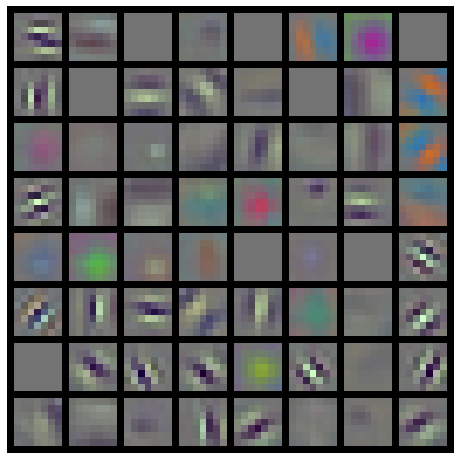

In [22]:
# layer = 1
filter = conv.model.conv1.weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [32]:
conv.model.layer1[1].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

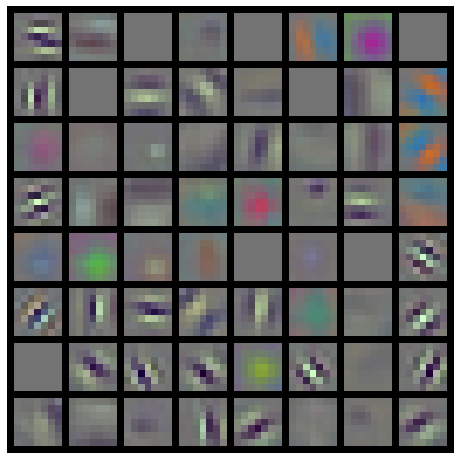

In [48]:
filter = conv.model.conv1.weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

## Feature Maps

In [10]:
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model

    def forward(self, x):
        return self.model(x)

In [14]:
class PretrainedModel_Conv(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet18(pretrained=True)
        self.model = model.conv1
    def forward(self, x):
        return self.model(x)

In [48]:
class PretrainedModel_Conv2(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def redefine(self):
        conv_model = self.model.layer1[1].conv2 # next layer, last conv
        self.model = conv_model

    def forward(self, x):
        return self.model(x)

In [ ]:
class PretrainedModel_Conv3(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model

    def forward(self, x):
        conv1 = self.model.conv1(x)
        layer1 = self.model.layer1(x)
        return self.model.conv1(x)

In [60]:
model_path = './outputs/checkpoints/given_dataset/base_models/model_skeleton_False.pt'
model = PretrainedModel(2)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [62]:
for i, param in enumerate(model.named_parameters()):
    print (i, param)

0 ('model.conv1.weight', Parameter containing:
tensor([[[[-8.7270e-03, -6.8631e-03, -3.5604e-03,  ...,  5.3551e-02,
            1.4999e-02, -1.4325e-02],
          [ 1.4805e-02,  1.0222e-02, -1.1145e-01,  ..., -2.7210e-01,
           -1.3015e-01,  2.3226e-03],
          [-2.6629e-03,  6.0091e-02,  2.9417e-01,  ...,  5.1884e-01,
            2.5500e-01,  6.1738e-02],
          ...,
          [-2.5388e-02,  1.5574e-02,  7.1170e-02,  ..., -3.3549e-01,
           -4.2263e-01, -2.5978e-01],
          [ 3.2532e-02,  4.1100e-02,  6.1667e-02,  ...,  4.1156e-01,
            3.9151e-01,  1.6332e-01],
          [-1.1949e-02, -4.0165e-03, -2.5586e-02,  ..., -1.5145e-01,
           -8.4080e-02, -6.8962e-03]],

         [[-9.7049e-03, -2.7347e-02, -3.6391e-02,  ...,  2.9457e-02,
           -1.4224e-03, -2.7375e-02],
          [ 4.9409e-02,  3.4298e-02, -1.0605e-01,  ..., -3.1339e-01,
           -1.6158e-01, -2.7024e-03],
          [ 3.4432e-03,  9.9422e-02,  4.0079e-01,  ...,  7.0701e-01,
           

### Old Attempt

In [4]:
def channeled_image_from_id(img_path, path_name, image_size): # will reshape to 3 channels! careful!
    arr = np.array(Image.open(img_path + path_name))
    # print(arr.shape)
    resized = cv2.resize(arr, (image_size[1], image_size[0])) # cv2.resize takes (width, height), which is (640, 480)!!
    # print(resized.shape)
    channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((image_size[0], image_size[1],3))
    # print(channels.shape)

    return channels

In [79]:
conv_model_only = PretrainedModel_Conv(2)

In [64]:
img_path = "/users/riya/race/dataset/segmentations/"

In [73]:
img = channeled_image_from_id(img_path,"82379.bmp", (224, 224))

In [82]:
feature_maps = conv_model_only(img)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


### New Attempt

In [63]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [86]:
data_dir = "/users/riya/race/classifier_experiments/CNN_train/dataset_filters/"
model_path = './outputs/checkpoints/given_dataset/base_models/model_skeleton_False.pt'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == 'cuda:1':
    torch.cuda.empty_cache()

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                        [0.5, 0.5, 0.5])])
    
test_folder = os.path.join(data_dir, 'test')
test_dataset = datasets.ImageFolder(test_folder, test_transforms)    

# Pytorch load model
conv = PretrainedModel(2)
conv.load_state_dict(torch.load(model_path))
conv.model.conv1.register_forward_hook(get_activation('conv1'))
conv.model.layer1[1].conv2.register_forward_hook(get_activation('layer1'))
# conv.model.layer2[1].conv2.register_forward_hook(get_activation('layer2[1].conv2'))


# load into Skorch
net = NeuralNetClassifier(conv, 
                          criterion=nn.CrossEntropyLoss,
                          device=device)

net.initialize() # bc I am not using net.fit (training the model)

output = net.predict_proba(test_dataset)
feature_maps_conv1 = activation['conv1']
feature_maps_layer1 = activation['layer1']

In [87]:
conv1_maps = np.array(torch.Tensor.cpu(feature_maps_conv1[0]))
layer1_maps = np.array(torch.Tensor.cpu(feature_maps_layer1[0]))

In [83]:
one_output.shape

(64, 112, 112)

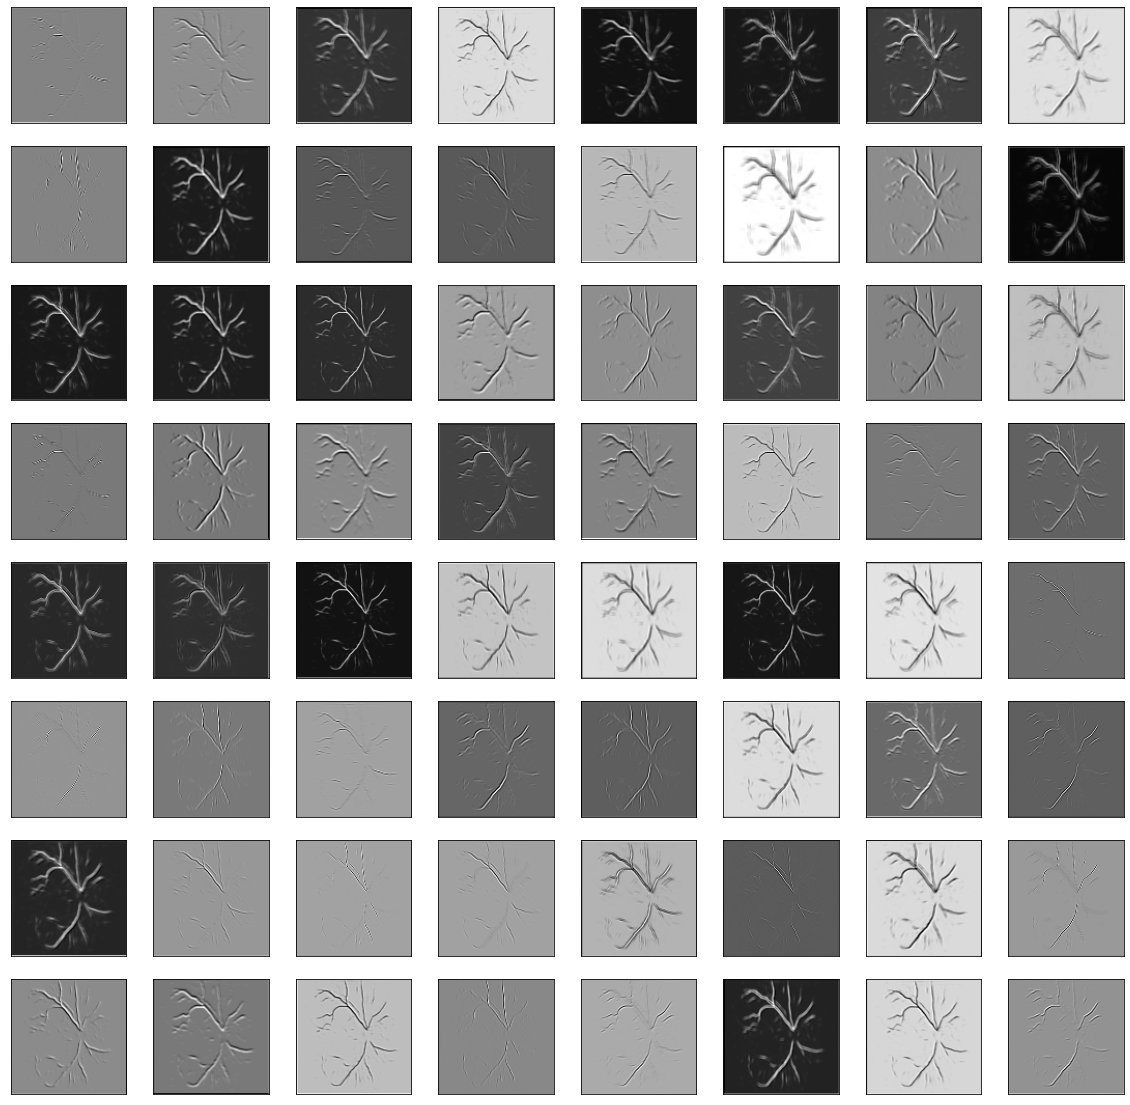

In [88]:
f, axarr = plt.subplots(8, 8)

plt.gcf().set_size_inches(20, 20)
    
idx = 0
for i in range(8):
    for j in range(8):
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
        axarr[i, j].imshow(conv1_maps[idx], cmap = 'gray')
        idx += 1

plt.show()

In [31]:
one_output[0].shape

(112, 112)

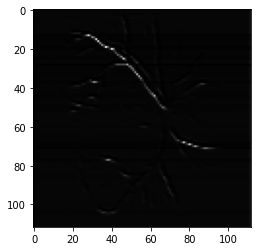

In [34]:
plt.imshow(one_output[1], cmap ='gray')

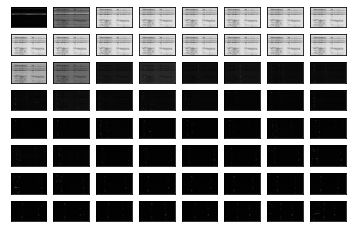

In [28]:
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [15]:
feature_maps[0]

array([[[0.00153242, 0.00326888, 0.00313355, ..., 0.00313355,
         0.00313355, 0.0018622 ],
        [0.00375558, 0.00359301, 0.00312199, ..., 0.00312199,
         0.00312199, 0.00298099],
        [0.00345665, 0.00352768, 0.0031233 , ..., 0.0031233 ,
         0.0031233 , 0.00292821],
        ...,
        [0.00345665, 0.00352768, 0.0031233 , ..., 0.0031233 ,
         0.0031233 , 0.00292821],
        [0.00345665, 0.00352768, 0.0031233 , ..., 0.0031233 ,
         0.0031233 , 0.00292821],
        [0.0027005 , 0.0032418 , 0.0031332 , ..., 0.0031332 ,
         0.0031332 , 0.00083429]],

       [[0.000498  , 0.00268665, 0.00314068, ..., 0.00314068,
         0.00314068, 0.00121984],
        [0.0008618 , 0.00271765, 0.00311614, ..., 0.00311614,
         0.00311614, 0.00860441],
        [0.0008949 , 0.00267619, 0.00311771, ..., 0.00311771,
         0.00311771, 0.00811389],
        ...,
        [0.0008949 , 0.00267619, 0.00311771, ..., 0.00311771,
         0.00311771, 0.00811389],
        [0.0